In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
from scipy import stats
import datetime as dt
import scipy.interpolate as interpolate
from mySSA import mySSA

In [2]:
volc = np.genfromtxt('nature14565-s6_sigl2015.csv', delimiter=",", dtype=float)
data_cook_2010 = np.genfromtxt('MADApdsi_cmz_v1.txt', delimiter=",", dtype=float) # ismr reconstruction

In [3]:
yy_cook_ann = np.arange(1300,2006)
ismr_cook_ann = data_cook_2010

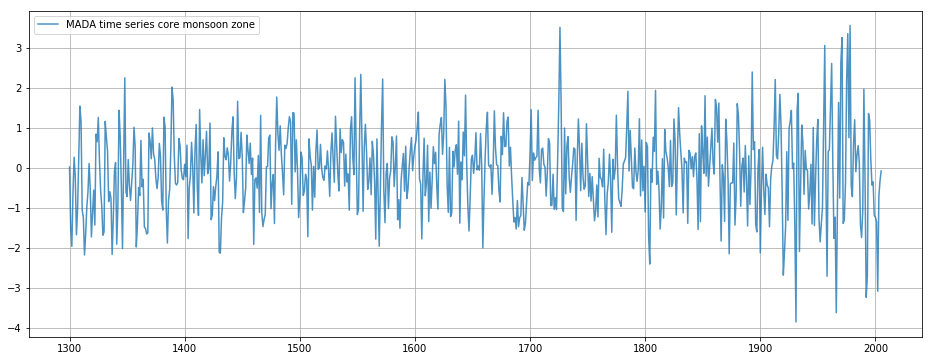

In [4]:
plt.figure(figsize=(16,6))
plt.plot(yy_cook_ann, ismr_cook_ann, label='MADA time series core monsoon zone', alpha=0.8)
plt.legend()
plt.grid()

In [5]:
# Singular Spectral Analysis as in Sinha et al 2015
def X_to_TS(X_i):
    """Averages the anti-diagonals of the given elementary matrix, X_i, and returns a time series."""
    # Reverse the column ordering of X_i
    X_rev = X_i[::-1]
    # Full credit to Mark Tolonen at https://stackoverflow.com/a/6313414 for this one:
    return np.array([X_rev.diagonal(i).mean() for i in range(-X_i.shape[0]+1, X_i.shape[1])])

def ssa(F):
    N = F.shape[0]
    L = 30# The window length.
    K = N - L + 1 # The number of columns in the trajectory matrix.
    # Create the trajectory matrix by pulling the relevant subseries of F, and stacking them as columns.
    X = np.column_stack([F[i:i+L] for i in range(0,K)])
    # Note: the i+L above gives us up to i+L-1, as numpy array upper bounds are exclusive. 
    d = np.linalg.matrix_rank(X) # The intrinsic dimensionality of the trajectory space.
    U, Sigma, V = np.linalg.svd(X)
    V = V.T # Note: the SVD routine returns V^T, not V, so I'll tranpose it back here. This may seem pointless, 
    X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )
    n = min(12,d) # In case of noiseless time series with d < 12.
    # Convert elementary matrices straight to a time series - no need to construct any Hankel matrices.
    F_i = np.zeros((n,N))
    for i in range(n):
        F_i[i,:] = X_to_TS(X_elem[i])
    return F_i


In [6]:
ismr_cook_ann_norm = (ismr_cook_ann - np.mean(ismr_cook_ann))/(np.std(ismr_cook_ann))

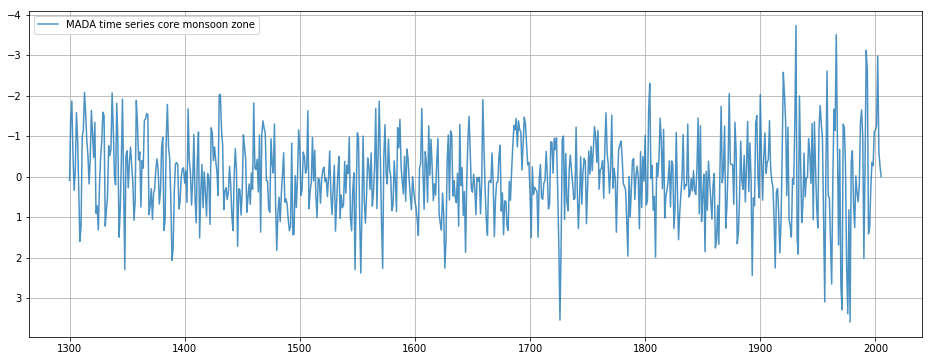

In [7]:
plt.figure(figsize=(16,6))
plt.plot(yy_cook_ann, ismr_cook_ann_norm, label='MADA time series core monsoon zone', alpha=0.8)
plt.gca().invert_yaxis()
plt.legend()
plt.grid()

The Palmer Drought Severity Index (PDSI) uses readily available temperature and precipitation data to estimate relative dryness. It is a standardized index that spans -10 (dry) to +10 (wet).

In [8]:
event_drought_cook = np.zeros((yy_cook_ann.shape[0]))
event_yy_volc_all = np.zeros((yy_cook_ann.shape[0]))
event_yy_volc_strong = np.zeros((yy_cook_ann.shape[0]))
event_yy_volc_all_trop = np.zeros((yy_cook_ann.shape[0]))
event_yy_volc_all_nh = np.zeros((yy_cook_ann.shape[0]))
event_yy_volc_all_sh = np.zeros((yy_cook_ann.shape[0]))
event_yy_volc_strong_trop = np.zeros((yy_cook_ann.shape[0]))
event_yy_volc_strong_nh = np.zeros((yy_cook_ann.shape[0]))
event_yy_volc_strong_sh = np.zeros((yy_cook_ann.shape[0]))

In [9]:
event_drought_cook[ismr_cook_ann_norm<-1.0] = 1.0

for i in range(yy_cook_ann.shape[0]):
    #print(event_yy_kobb[i])
    idx = np.asarray(np.where(volc[:,0] == yy_cook_ann[i]))
    #print(idx.size)
    if idx.size==0:
        continue
    event_yy_volc_all[i] = 1.0
    if np.abs(volc[idx[0,0],2])>=5.0:
        event_yy_volc_strong[i] = 1.0
    
    if volc[idx[0,0],1] == 1.0:
        event_yy_volc_all_trop[i] = 1.0
    if volc[idx[0,0],1] == 2.0:
        event_yy_volc_all_nh[i] = 1.0
    if volc[idx[0,0],1] == 3.0:
        event_yy_volc_all_sh[i] = 1.0
        
    if (volc[idx[0,0],1] == 1.0) & (np.abs(volc[idx[0,0],2])>=3.7):
        event_yy_volc_strong_trop[i] = 1.0
    if (volc[idx[0,0],1] == 2.0) & (np.abs(volc[idx[0,0],2])>=3.7):
        event_yy_volc_strong_nh[i] = 1.0
    if (volc[idx[0,0],1] == 3.0) & (np.abs(volc[idx[0,0],2])>=3.7):
        event_yy_volc_strong_sh[i] = 1.0

In [10]:
np.savetxt('drought_cook_2010.txt', event_drought_cook, delimiter=",")
np.savetxt('all_volc_cook_2010.txt', event_yy_volc_all, delimiter=",")
np.savetxt('strong_volc_cook_2010.txt', event_yy_volc_strong, delimiter=",")
np.savetxt('all_tropical_cook_2010.txt', event_yy_volc_all_trop, delimiter=",")
np.savetxt('strong_tropical_cook_2010.txt', event_yy_volc_strong_trop, delimiter=",")
np.savetxt('all_nh_cook_2010.txt', event_yy_volc_all_nh, delimiter=",")
np.savetxt('strong_nh_cook_2010.txt', event_yy_volc_strong_nh, delimiter=",")
np.savetxt('all_sh_cook_2010.txt', event_yy_volc_all_sh, delimiter=",")
np.savetxt('strong_sh_cook_2010.txt', event_yy_volc_strong_sh, delimiter=",")

In [11]:
print(np.sum(event_yy_volc_all))
print(np.sum(event_yy_volc_strong))
print(np.sum(event_yy_volc_all_trop))
print(np.sum(event_yy_volc_strong_trop))
print(np.sum(event_yy_volc_all_nh))
print(np.sum(event_yy_volc_strong_nh))
print(np.sum(event_yy_volc_all_sh))
print(np.sum(event_yy_volc_strong_sh))

89.0
14.0
26.0
16.0
45.0
1.0
18.0
0.0


In [12]:
# Bootstrap
N = 1000
win = 5
count_elnino_all_volc = np.zeros((N, win))
count_elnino_strong_volc  = np.zeros((N, win))
count_elnino_all_trop  = np.zeros((N, win))
count_elnino_strong_trop  = np.zeros((N, win))
count_elnino_all_nh  = np.zeros((N, win))
count_elnino_strong_nh  = np.zeros((N, win))
count_elnino_all_sh  = np.zeros((N, win))

In [13]:
idx_all = np.asarray(np.where(event_yy_volc_all == 1.0))
idx_strong = np.asarray(np.where(event_yy_volc_strong == 1.0))
idx_all_trop = np.asarray(np.where(event_yy_volc_all_trop == 1.0))
idx_strong_trop = np.asarray(np.where(event_yy_volc_strong_trop == 1.0))
idx_all_nh = np.asarray(np.where(event_yy_volc_all_nh == 1.0))
idx_strong_nh = np.asarray(np.where(event_yy_volc_strong_nh == 1.0))
idx_all_sh = np.asarray(np.where(event_yy_volc_all_sh == 1.0))

In [14]:
print(idx_all[0])

[  6  29  36  41  45  78  81  89 108 114 116 141 148 153 158 163 170 177
 178 180 202 205 212 228 237 241 254 267 276 285 290 295 301 319 321 337
 341 346 354 362 367 373 393 395 408 419 420 421 425 429 439 456 462 466
 470 483 486 496 497 509 515 521 523 532 536 546 553 556 562 573 575 584
 587 590 603 608 612 619 625 626 631 643 647 657 664 668 679 682 691]


In [15]:
niter = 0
while niter<N:
    rand_year_all = random.sample(list(idx_all[0]), 1)
    if (rand_year_all[0]<ismr_cook_ann_norm.shape[0]-win):
        count_elnino_all_volc[niter,:] = ismr_cook_ann_norm[rand_year_all[0]:rand_year_all[0]+win]
    
    rand_year_strong = random.sample(list(idx_strong[0]), 1)
    if (rand_year_strong[0]<ismr_cook_ann_norm.shape[0]-win):
        count_elnino_strong_volc[niter,:] = ismr_cook_ann_norm[rand_year_strong[0]:rand_year_strong[0]+win]
    
    rand_year_all_trop = random.sample(list(idx_all_trop[0]), 1)
    if (rand_year_all_trop[0]<ismr_cook_ann_norm.shape[0]-win):
        count_elnino_all_trop[niter,:] = ismr_cook_ann_norm[rand_year_all_trop[0]:rand_year_all_trop[0]+win]

    rand_year_strong_trop = random.sample(list(idx_strong_trop[0]), 1)
    if (rand_year_strong_trop[0]<ismr_cook_ann_norm.shape[0]-win):
        count_elnino_strong_trop[niter,:] = ismr_cook_ann_norm[rand_year_strong_trop[0]:rand_year_strong_trop[0]+win]

    rand_year_all_nh = random.sample(list(idx_all_nh[0]), 1)
    if (rand_year_all_nh[0]<ismr_cook_ann_norm.shape[0]-win):
        count_elnino_all_nh[niter,:] = ismr_cook_ann_norm[rand_year_all_nh[0]:rand_year_all_nh[0]+win]

    rand_year_strong_nh = random.sample(list(idx_strong_nh[0]), 1)
    if (rand_year_strong_nh[0]<ismr_cook_ann_norm.shape[0]-win):
        count_elnino_strong_nh[niter,:] = ismr_cook_ann_norm[rand_year_strong_nh[0]:rand_year_strong_nh[0]+win]

    rand_year_all_sh = random.sample(list(idx_all_sh[0]), 1)
    if (rand_year_all_sh[0]<ismr_cook_ann_norm.shape[0]-win):
        count_elnino_all_sh[niter,:] = ismr_cook_ann_norm[rand_year_all_sh[0]:rand_year_all_sh[0]+win]
    
    #print(s[rand_year_all[0]:rand_year_all[0]+win])
    #print(rand_year_all[0])
    niter = niter + 1 

/iitm2/cccr-res/msingh/anaconda3/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


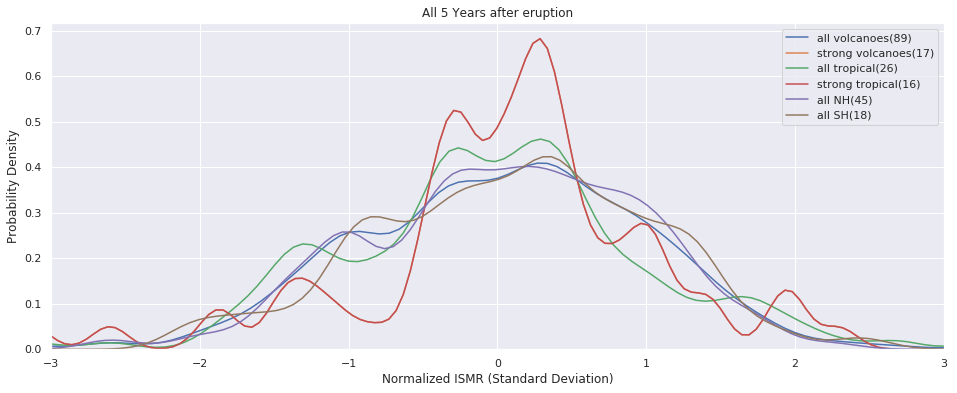

In [16]:
import seaborn as sns; sns.set(color_codes=True)
plt.figure(figsize=(16,6))
sns.kdeplot(count_elnino_all_volc.flatten(), label='all volcanoes(89)')
sns.kdeplot(count_elnino_strong_volc.flatten(), label='strong volcanoes(17)')
sns.kdeplot(count_elnino_all_trop.flatten(), label='all tropical(26)')
sns.kdeplot(count_elnino_strong_volc.flatten(), label='strong tropical(16)')
sns.kdeplot(count_elnino_all_nh.flatten(), label='all NH(45)')
#sns.kdeplot(count_elnino_strong_nh.flatten(), label='strong NH(1)')
sns.kdeplot(count_elnino_all_sh.flatten(), label='all SH(18)')
plt.title('All 5 Years after eruption')
plt.ylabel('Probability Density')
plt.xlabel('Normalized ISMR (Standard Deviation)')
plt.xlim([-3,3])
plt.legend()

/iitm2/cccr-res/msingh/anaconda3/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


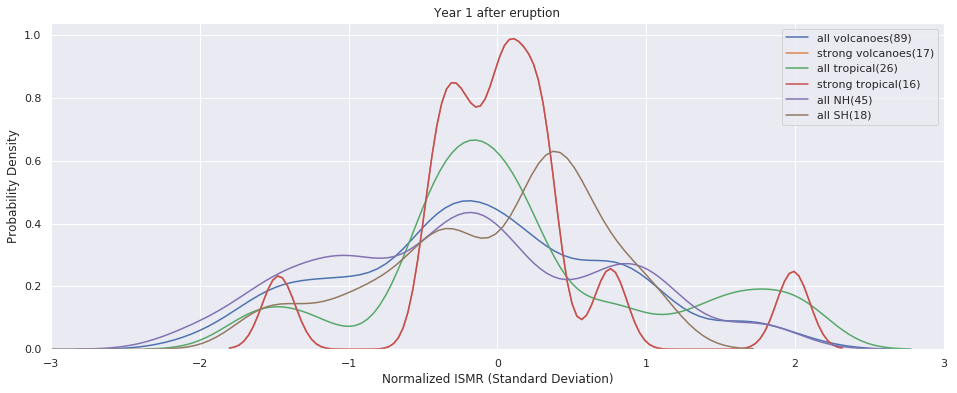

In [17]:
import seaborn as sns; sns.set(color_codes=True)
plt.figure(figsize=(16,6))
sns.kdeplot(count_elnino_all_volc[:,0], label='all volcanoes(89)')
sns.kdeplot(count_elnino_strong_volc[:,0], label='strong volcanoes(17)')
sns.kdeplot(count_elnino_all_trop[:,0], label='all tropical(26)')
sns.kdeplot(count_elnino_strong_volc[:,0], label='strong tropical(16)')
sns.kdeplot(count_elnino_all_nh[:,0], label='all NH(45)')
#sns.kdeplot(count_elnino_strong_nh[:,0], label='strong NH(1)')
sns.kdeplot(count_elnino_all_sh[:,0], label='all SH(18)')
plt.title('Year 1 after eruption')
plt.ylabel('Probability Density')
plt.xlabel('Normalized ISMR (Standard Deviation)')
plt.xlim([-3,3])
plt.legend()

/iitm2/cccr-res/msingh/anaconda3/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


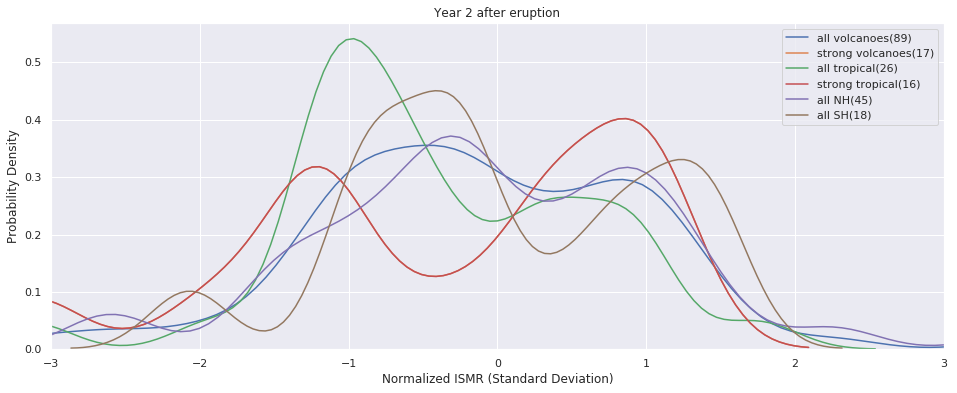

In [18]:
import seaborn as sns; sns.set(color_codes=True)
plt.figure(figsize=(16,6))
sns.kdeplot(count_elnino_all_volc[:,1], label='all volcanoes(89)')
sns.kdeplot(count_elnino_strong_volc[:,1], label='strong volcanoes(17)')
sns.kdeplot(count_elnino_all_trop[:,1], label='all tropical(26)')
sns.kdeplot(count_elnino_strong_volc[:,1], label='strong tropical(16)')
sns.kdeplot(count_elnino_all_nh[:,1], label='all NH(45)')
#sns.kdeplot(count_elnino_strong_nh[:,1], label='strong NH(1)')
sns.kdeplot(count_elnino_all_sh[:,1], label='all SH(18)')
plt.title('Year 2 after eruption')
plt.ylabel('Probability Density')
plt.xlabel('Normalized ISMR (Standard Deviation)')
plt.xlim([-3,3])
plt.legend()

/iitm2/cccr-res/msingh/anaconda3/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


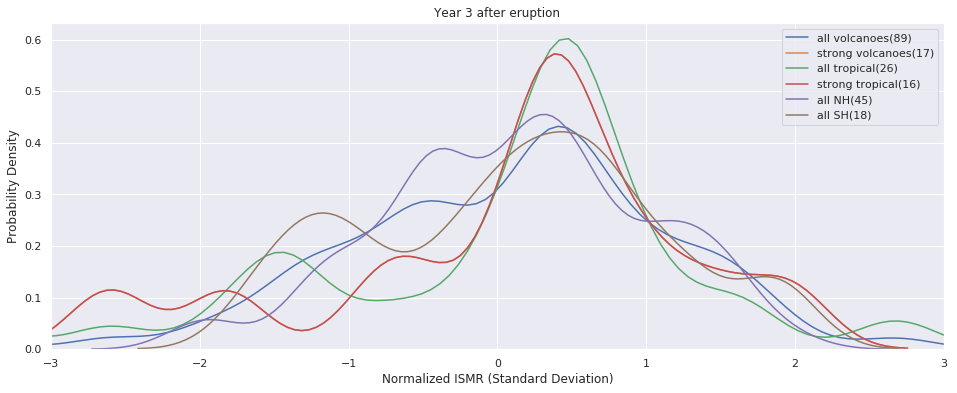

In [19]:
import seaborn as sns; sns.set(color_codes=True)
plt.figure(figsize=(16,6))
sns.kdeplot(count_elnino_all_volc[:,2], label='all volcanoes(89)')
sns.kdeplot(count_elnino_strong_volc[:,2], label='strong volcanoes(17)')
sns.kdeplot(count_elnino_all_trop[:,2], label='all tropical(26)')
sns.kdeplot(count_elnino_strong_volc[:,2], label='strong tropical(16)')
sns.kdeplot(count_elnino_all_nh[:,2], label='all NH(45)')
#sns.kdeplot(count_elnino_strong_nh[:,2], label='strong NH(1)')
sns.kdeplot(count_elnino_all_sh[:,2], label='all SH(18)')
plt.title('Year 3 after eruption')
plt.ylabel('Probability Density')
plt.xlabel('Normalized ISMR (Standard Deviation)')
plt.xlim([-3,3])
plt.legend()

/iitm2/cccr-res/msingh/anaconda3/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


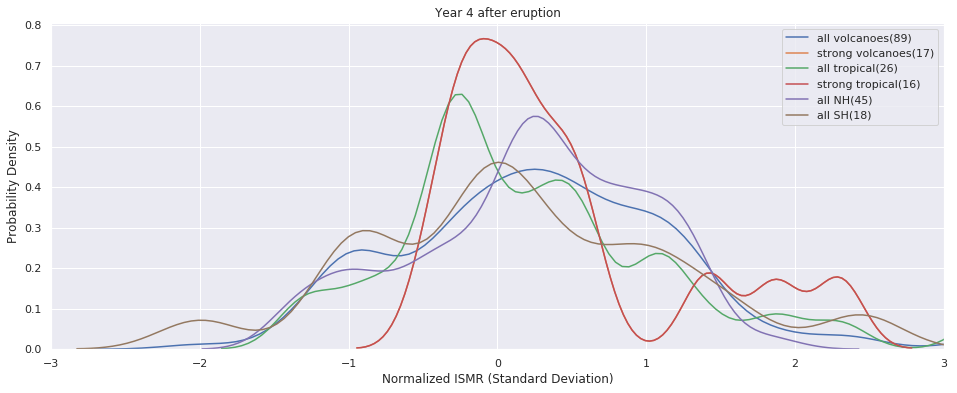

In [20]:
import seaborn as sns; sns.set(color_codes=True)
plt.figure(figsize=(16,6))
sns.kdeplot(count_elnino_all_volc[:,3], label='all volcanoes(89)')
sns.kdeplot(count_elnino_strong_volc[:,3], label='strong volcanoes(17)')
sns.kdeplot(count_elnino_all_trop[:,3], label='all tropical(26)')
sns.kdeplot(count_elnino_strong_volc[:,3], label='strong tropical(16)')
sns.kdeplot(count_elnino_all_nh[:,3], label='all NH(45)')
#sns.kdeplot(count_elnino_strong_nh[:,3], label='strong NH(1)')
sns.kdeplot(count_elnino_all_sh[:,3], label='all SH(18)')
plt.title('Year 4 after eruption')
plt.ylabel('Probability Density')
plt.xlabel('Normalized ISMR (Standard Deviation)')
plt.xlim([-3,3])
plt.legend()

/iitm2/cccr-res/msingh/anaconda3/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


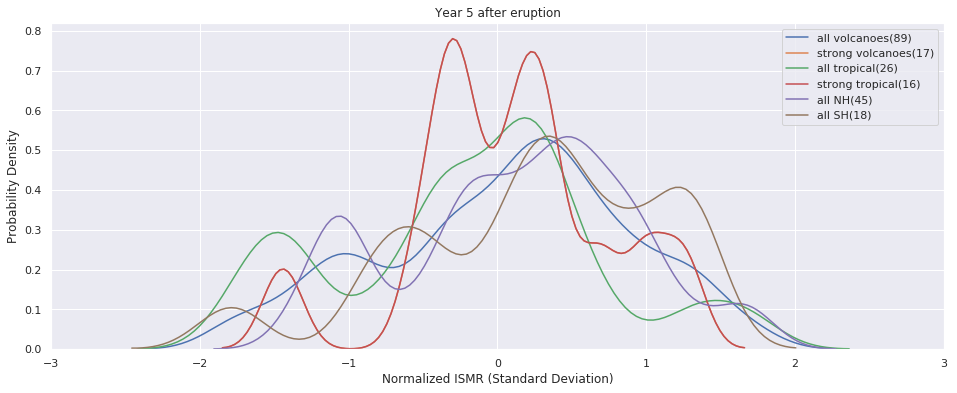

In [21]:
import seaborn as sns; sns.set(color_codes=True)
plt.figure(figsize=(16,6))
sns.kdeplot(count_elnino_all_volc[:,4], label='all volcanoes(89)')
sns.kdeplot(count_elnino_strong_volc[:,4], label='strong volcanoes(17)')
sns.kdeplot(count_elnino_all_trop[:,4], label='all tropical(26)')
sns.kdeplot(count_elnino_strong_volc[:,4], label='strong tropical(16)')
sns.kdeplot(count_elnino_all_nh[:,4], label='all NH(45)')
#sns.kdeplot(count_elnino_strong_nh[:,4], label='strong NH(1)')
sns.kdeplot(count_elnino_all_sh[:,4], label='all SH(18)')
plt.title('Year 5 after eruption')
plt.ylabel('Probability Density')
plt.xlabel('Normalized ISMR (Standard Deviation)')
plt.xlim([-3,3])
plt.legend()

In [22]:
ismr_cook_anom_yy = np.zeros((ismr_cook_ann_norm.shape[0],3))
ismr_cook_anom_yy[:,0] = yy_cook_ann[:]
ismr_cook_anom_yy[:,1] = event_yy_volc_strong[:]
ismr_cook_anom_yy[:,2] = ismr_cook_ann_norm[:]
np.savetxt('ismr_cook_anom_yy.txt', ismr_cook_anom_yy, delimiter=",")